In [18]:
import pandas as pd
import numpy as np

#Modelisation
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

#Fonction test model
from Test_Model import test_model
%matplotlib inline

# III/ Comparaison de l'erreur de prédiction de différentes méthodes statistiques

Jusqu'à maintenant, nous avons démontré que les stratégies d'investissements obtenues à partir de la résolution du problème de Markovitz (équivalent à la résolution d'un problème des moindres carrés => démonstration dans le fichier LaTeX) ne sont pas très convaincantes. Nous allons donc tester plusieurs autres méthodes statistiques de prédiction des rendements futurs et allons mettre en place une métrique commune qui mesure l'erreur de prédiction obtenue. 



Ici on crée l'interface qui nous permet de choisir le nombre d'actifs considéré, le nombre de dates, la vraie loi des rendements

In [5]:
nb_actifs = 20
nb_dates = 256 * 5

idx = pd.Index(np.arange(nb_actifs))
idx_date = pd.Index(np.arange(nb_dates))

esp_rdt = 0.05
vol_rdt = 0.2
correl = 0.7
seuil_pb_marko = 0.05
mu = pd.Series(esp_rdt,index=idx)
vols = pd.Series(vol_rdt,index=idx)
#Le vecteur constant cible que l'on essayer d'estimer -> chaque composante du vecteur est le rendement du protefeuille optimal tous  les jours
allocation_optimale_théorique = pd.Series(esp_rdt, index = idx_date)

#Matrice var-covar théorique selon la vraie loi des rendements
covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vols)

In [6]:
#On simuler un tirage de rendements suivant une loi normale d'espérence Mu et de Var la matrice Covar
A = np.linalg.cholesky(covar)
rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16

Ici on calcule les estimateurs d'espérance et de variance empiriques de la série des observations

In [7]:
mu_estime = rdts_observes.mean() * 256
covar_estimee = rdts_observes.cov() * 256

#Suivant la formule de la résolution du problème, on calcule l'allocation optimale "in sample"

covar_inv = np.linalg.inv(covar_estimee)
df_covar_inv = pd.DataFrame(covar_inv,index=idx,columns=idx)
lambda1 = seuil_pb_marko/(mu_estime @ df_covar_inv @ mu_estime)
alloc_optimale_in_sample = lambda1 * (df_covar_inv @ mu_estime)

A priori, nous pouvons nous ramener à la résolution d'un problème des moindres carrés. Donc nous allons effectuer la régression de la vraie allocation optimale sur les rendements observés. Le Beta que l'on obtient devrait être le plus proche possible de l'allocation optimale théorique. 

In [8]:
print(allocation_optimale_théorique)

0       0.05
1       0.05
2       0.05
3       0.05
4       0.05
        ... 
1275    0.05
1276    0.05
1277    0.05
1278    0.05
1279    0.05
Length: 1280, dtype: float64


In [9]:
regression = LinearRegression()

# Entraîner le modèle sur les données
regression.fit(rdts_observes, allocation_optimale_théorique)

# Obtenir les coefficients de la régression
coefficients = regression.coef_
intercept = regression.intercept_

On réalise la régression sans intercept car la variable sur laquelle on régresse est colinéaire avec le vecteur constant égale à 1

In [10]:
regression_sans_intercept = LinearRegression(fit_intercept = False)

# Entraîner le modèle sur les données
regression_sans_intercept.fit(rdts_observes, allocation_optimale_théorique)

# Obtenir les coefficients de la régression
coefficients_bis = regression_sans_intercept.coef_
intercept_bis = regression_sans_intercept.intercept_

On normalise le vecteur d'allocation entre les actifs in sample afin que la somme de ses poids soit égale à 1 et pareil pour le vecteur des coefficients qui sort de la régression sans intercept. 

On voit que l'on retrouve bien l'allocation in sample de la partie I. 

In [11]:
#Coefficients problème de Markovitz
alloc_optimale_in_sample_normalized = alloc_optimale_in_sample * (1 / sum(alloc_optimale_in_sample))
#Coefficients issues de la régression
coefficients_bis_normalized = coefficients_bis * (1 / sum(coefficients_bis))

print(alloc_optimale_in_sample_normalized - coefficients_bis_normalized)

0    -3.774758e-14
1    -3.819167e-14
2    -1.121325e-14
3    -2.753353e-14
4    -4.418688e-14
5    -9.858780e-14
6     4.307665e-14
7     6.927792e-14
8    -1.145750e-13
9     5.284662e-14
10    5.151435e-14
11   -1.887379e-15
12   -4.396483e-14
13    4.551914e-15
14   -3.730349e-14
15   -4.884981e-14
16    7.682743e-14
17    7.194245e-14
18    1.048051e-13
19    3.064216e-14
dtype: float64


## A/ Régressions pénalisées

Dans cette partie, nous allons tester des régressions pénalisées afin de pouvoir comparer l'erreur de prédiction avec les précédentes méthodes

### 1/ Création des échantillons train/test

Ici, nous allons régresser le vecteur "allocation_optimale_theorique" qui est un vecteur colinéaire au vecteur constant égal à 1 et qui contient la performance, jour par jour, du portfolio optimal dans notre exemple

In [12]:
X_train = rdts_observes
Y_train = allocation_optimale_théorique

X_test = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16
Y_test = allocation_optimale_théorique #Car les lois des actifs n'ont pas été modifiées

R_2 du modèle : 0.0
Le MSE (Mean Squared Error) de notre prédiction est de 4.81482486096809e-35
Le MAE (Mean Absolute Error) de notre prédiction est de 6.938893903907228e-18


AttributeError: 'Series' object has no attribute 'reshape'

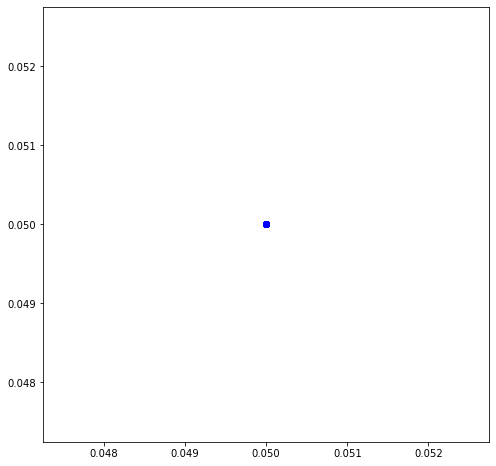

In [16]:
test_model(X_train, X_test, Y_train, Y_test, X_train, LassoCV())

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.004011,-0.006507,-0.008014,-0.005071,-0.003630,-0.007668,-0.004176,-0.012745,0.000866,-0.001367,-0.000713,0.004700,0.000345,0.005222,0.006773,0.001946,0.002605,-0.005131,-0.004204,0.000065
1,-0.029332,-0.006098,-0.010613,-0.019406,-0.001325,-0.019010,-0.011383,-0.017337,-0.013397,-0.022939,-0.016286,0.003045,-0.002804,-0.013797,-0.008263,-0.008861,-0.012145,-0.022775,-0.027990,-0.005366
2,-0.013123,-0.000320,-0.016851,-0.002304,-0.005287,-0.009148,0.002058,-0.024080,0.000432,-0.010963,-0.010186,-0.001193,-0.007121,-0.010610,-0.001295,-0.007413,-0.011048,-0.008058,-0.004800,-0.012194
3,0.004652,0.011380,-0.006680,0.014287,0.009830,0.009048,0.012692,0.016519,0.001373,0.018280,0.014722,0.005099,0.020591,0.004118,0.006223,0.015918,0.005520,-0.000505,-0.000263,-0.000340
4,0.003386,-0.001456,0.010897,-0.002985,0.003557,0.002550,0.008748,-0.004806,0.009995,0.007336,0.003410,0.012035,0.003713,-0.000140,0.005767,0.002755,0.009410,0.005743,0.010561,0.011862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,0.004347,0.001190,-0.001190,0.007826,0.004810,-0.004741,-0.001049,-0.011770,0.001982,0.001959,-0.006323,0.007129,-0.011983,-0.002045,0.010129,-0.005878,0.007613,-0.005334,-0.009540,0.009312
1276,-0.001494,0.008845,-0.000767,-0.001391,0.003421,0.001082,0.001187,-0.004457,0.002903,0.001984,0.004237,0.007902,0.009360,0.010252,0.000723,0.013542,0.006076,0.002470,0.001906,0.010899
1277,0.021684,0.020739,0.009811,0.014797,0.020185,0.009602,0.024353,0.018817,0.015629,0.011164,0.016427,0.001249,0.022068,0.016604,0.005127,0.018039,0.017239,0.033714,0.021533,0.011194
1278,-0.019375,-0.012638,-0.016942,-0.013082,-0.015119,-0.015928,-0.007209,-0.016882,-0.017976,-0.005162,-0.005515,-0.021445,-0.017442,-0.015287,-0.013872,-0.014736,-0.023975,-0.019911,-0.012303,-0.022733
